In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pickle as pkl
import statsmodels.api as sm
from scipy.stats import shapiro, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [11]:
data = pd.read_csv('Dubizzle_properties_cleaned.csv')
data.head()

,Unnamed: 0,link,title,price,down_payment,location,creation_date,property_type,ownership,area,bedrooms,bathrooms,furnished,payment_option,completion_status,amenities,ad_id,seller_type,seller_name,seller_member_since,area_name,city,seller_member_since_year,amenities_count_full,has_garden,has_security,has_pool,has_balcony,has_parking,has_elevator,location_encoded
0,0,https://www.dubizzle.com.eg/en/ad/ready-to-liv...,Ready to live in - apartment for sale at Mount...,5328000,4680000.0,"Mountain View iCity Compound, 6th of October",2025-08-14,Apartment,Resale,114.0,2.0,2,No,Installment,Ready,"Balcony, Security, Pets Allowed, Electricity M...",501924822,Listed by agency,Square Feet,Member since Jan 2025,Mountain View iCity Compound,6th of October,2025,7,False,True,False,True,False,False,343
1,1,https://www.dubizzle.com.eg/en/ad/apartment-fo...,"Apartment for sale in Al Rehab, near services,...",10500000,0.0,"Rehab City Compound, New Cairo",2025-08-13,Apartment,Resale,200.0,3.0,3,No,Cash,Ready,"Balcony, Private Garden, Security, Electricity...",501847438,Listed by agency,Escan,Member since Jan 2024,Rehab City Compound,New Cairo,2024,7,True,True,False,True,False,False,422
2,2,https://www.dubizzle.com.eg/en/ad/invest-in-ap...,Invest in apartment with size 103 sqm - Privat...,6437500,917345.0,"Hurghada, Red Sea",2025-08-15,Apartment,Primary,103.0,2.0,2,No,Installment,Off-plan,"Balcony, Security, Pool, Electricity Meter, Wa...",501836294,Listed by agency,اميرالد للتسويق و الاستشارات و الاستثمارات الع...,Member since Oct 2023,Hurghada,Red Sea,2023,8,False,True,True,True,False,True,244
3,3,https://www.dubizzle.com.eg/en/ad/under-market...,Under Market Price Apartment for Sale in Andal...,4100000,0.0,"Andalus, New Cairo",2025-08-14,Apartment,Resale,185.0,3.0,2,No,Cash,Ready,"Balcony, Security, Covered Parking",501712573,Listed by agency,New Avenue,Member since Mar 2024,Andalus,New Cairo,2024,3,False,True,False,True,True,False,71
4,4,https://www.dubizzle.com.eg/en/ad/%D8%B4%D9%82...,شقة غرفتين للبيع جنب نادي الزمالك في اكتوبر با...,4900000,490000.0,"Zat, 6th of October",2025-08-13,Apartment,Primary,112.0,2.0,2,No,Installment,Ready,Unknown,501684842,Listed by agency,Abrag Three,Member since Feb 2025,Zat,6th of October,2025,0,False,False,False,False,False,False,545


In [12]:
# Select columns for modeling
model_cols = [
    'area_name', 'city', 'location_encoded', 'property_type', 'ownership', 'area',
    'bedrooms', 'bathrooms', 'furnished', 'payment_option', 'completion_status',
    'amenities_count_full', 'has_garden', 'has_security', 'has_pool', 'has_balcony',
    'has_parking', 'has_elevator', 'down_payment', 'price'
]
data = data[model_cols]

In [13]:
data['price_per_sqm'] = data.apply(lambda x: x['price'] / x['area'] if x['area'] != 0 else np.nan, axis=1)


In [14]:
data.head()


,area_name,city,location_encoded,property_type,ownership,area,bedrooms,bathrooms,furnished,payment_option,completion_status,amenities_count_full,has_garden,has_security,has_pool,has_balcony,has_parking,has_elevator,down_payment,price,price_per_sqm
0,Mountain View iCity Compound,6th of October,343,Apartment,Resale,114.0,2.0,2,No,Installment,Ready,7,False,True,False,True,False,False,4680000.0,5328000,46736.842105
1,Rehab City Compound,New Cairo,422,Apartment,Resale,200.0,3.0,3,No,Cash,Ready,7,True,True,False,True,False,False,0.0,10500000,52500.000000
2,Hurghada,Red Sea,244,Apartment,Primary,103.0,2.0,2,No,Installment,Off-plan,8,False,True,True,True,False,True,917345.0,6437500,62500.000000
3,Andalus,New Cairo,71,Apartment,Resale,185.0,3.0,2,No,Cash,Ready,3,False,True,False,True,True,False,0.0,4100000,22162.162162
4,Zat,6th of October,545,Apartment,Primary,112.0,2.0,2,No,Installment,Ready,0,False,False,False,False,False,False,490000.0,4900000,43750.000000


In [15]:
data.shape


(4938, 21)

In [16]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4938 entries, 0 to 4937
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area_name             4938 non-null   object 
 1   city                  4938 non-null   object 
 2   location_encoded      4938 non-null   int64  
 3   property_type         4938 non-null   object 
 4   ownership             4938 non-null   object 
 5   area                  4938 non-null   float64
 6   bedrooms              4937 non-null   float64
 7   bathrooms             4938 non-null   int64  
 8   furnished             4938 non-null   object 
 9   payment_option        4938 non-null   object 
 10  completion_status     4938 non-null   object 
 11  amenities_count_full  4938 non-null   int64  
 12  has_garden            4938 non-null   bool   
 13  has_security          4938 non-null   bool   
 14  has_pool              4938 non-null   bool   
 15  has_balcony          

In [17]:
data.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
area_name,4938,533,Madinaty,322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,4938,56,5th Settlement,1129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_encoded,4938.0,NaN,NaN,NaN,293.715674,151.518459,0.0,180.0,302.0,422.0,553.0
property_type,4938,6,Apartment,4422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ownership,4938,2,Primary,2538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,4938.0,NaN,NaN,NaN,162.637446,62.815571,22.0,125.0,156.0,190.0,800.0
bedrooms,4937.0,NaN,NaN,NaN,2.731416,0.751532,1.0,2.0,3.0,3.0,8.0
bathrooms,4938.0,NaN,NaN,NaN,2.337586,0.83452,1.0,2.0,2.0,3.0,8.0
furnished,4938,2,No,4623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_option,4938,3,Cash,2820,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data.isna().sum().sum()


np.int64(1)

In [19]:
data.dropna(inplace=True)


In [20]:
data.drop_duplicates(inplace=True)


In [21]:
data.duplicated().sum()

np.int64(0)

In [22]:
# Check multicollinearity
numeric_cols_vif = ['area', 'bedrooms', 'bathrooms', 'amenities_count_full', 'down_payment', 'price_per_sqm']
X_numeric = data[numeric_cols_vif].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols_vif
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print("VIF for Numeric Features:")
print(vif_data)

VIF for Numeric Features:
                Feature        VIF
0                  area  17.763232
1              bedrooms  22.414189
2             bathrooms  18.499493
3  amenities_count_full   2.749490
4          down_payment   1.305748
5         price_per_sqm   3.515512


In [23]:
## Feature Engineering
# Split data with stratification
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42, stratify=data['property_type'])
# Apply log1p to price
train_data['price_log'] = np.log1p(train_data['price'])
test_data['price_log'] = np.log1p(test_data['price'])



In [24]:
# Define categorical and numeric columns
categorical_cols = ['area_name', 'city', 'property_type', 'ownership', 'furnished', 'payment_option', 'completion_status']
numeric_cols = ['location_encoded', 'area', 'bedrooms', 'bathrooms', 'amenities_count_full',
                'has_garden', 'has_security', 'has_pool', 'has_balcony', 'has_parking', 'has_elevator',
                'down_payment', 'price_per_sqm']

In [25]:
# Preprocessing for non-CatBoost models
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

In [26]:
# Initialize dictionary to store model results
model_results = []

# Function to evaluate and plot model performance
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name):
    # Check for missing values
    if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
        raise ValueError("Missing values found in X_train or X_test")
    if y_train.isnull().sum() > 0 or y_test.isnull().sum() > 0:
        raise ValueError("Missing values found in y_train or y_test")

    # Fit the model
    pipeline.fit(X_train, y_train)
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)

    # Check for inf or NaN in predictions
    if np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred)):
        raise ValueError("Predictions contain inf or NaN values")

    # Calculate metrics
    r2 = r2_score(y_test_real, y_pred)
    mae = mean_absolute_error(y_test_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    # Shapiro-Wilk test for residuals normality (only if sample size is reasonable)
    residuals = y_test_real - y_pred
    shapiro_stat, shapiro_p = shapiro(residuals) if len(residuals) <= 5000 else (np.nan, np.nan)

    # Store results
    model_results.append({
        'Model': model_name,
        'R²': r2,
        'MAE (EGP)': mae,
        'RMSE (EGP)': rmse,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std(),
        'Shapiro p-value': shapiro_p
    })

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))

    # Scatter plot: Actual vs Predicted
    sns.scatterplot(x=y_test_real, y=y_pred, ax=axes[0], color='dodgerblue', s=25, alpha=0.6)
    axes[0].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], '--r', linewidth=1)
    axes[0].set_title(f'{model_name}: Actual vs Predicted Prices (EGP)')
    axes[0].set_xlabel('Actual Price (EGP)')
    axes[0].set_ylabel('Predicted Price (EGP)')
    axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Histogram of Residuals
    sns.histplot(residuals, bins=50, kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f'{model_name}: Residuals Distribution (EGP)')
    axes[1].set_xlabel('Residual (y_true - y_pred)')
    axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Q-Q Plot
    sm.qqplot(residuals, dist=norm, line='45', ax=axes[2])
    axes[2].set_title(f'{model_name}: Q-Q Plot of Residuals')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"{model_name} Results:")
    print(f"Test R² Score  : {r2:.4f}")
    print(f"Test MAE       : {mae:,.0f} EGP")
    print(f"Test RMSE      : {rmse:,.0f} EGP")
    print(f"Cross-Validation R² Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}" if not np.isnan(shapiro_p) else "Shapiro-Wilk skipped (sample size > 5000)")

    return pipeline

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


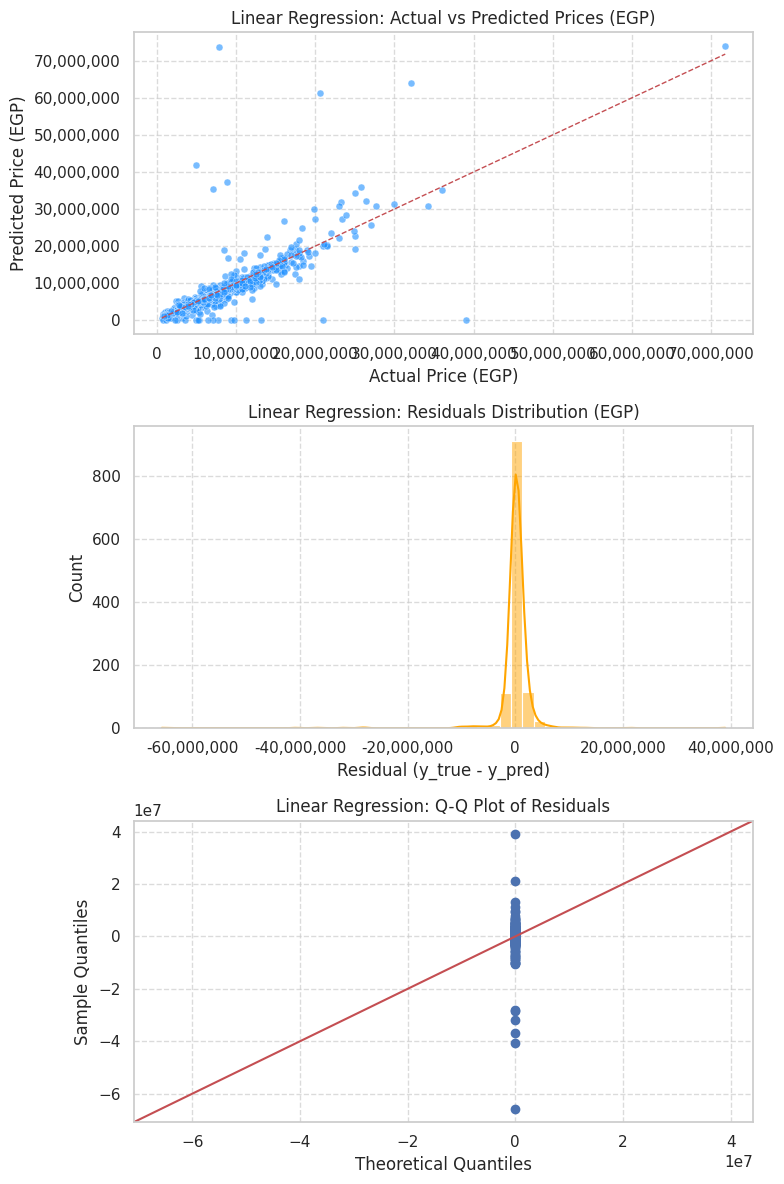

Linear Regression Results:
Test R² Score  : 0.5031
Test MAE       : 1,175,806 EGP
Test RMSE      : 3,554,851 EGP
Cross-Validation R² Mean: -1.3524 ± 4.0132
Shapiro-Wilk p-value: 0.0000


In [27]:
# Modeling
# Model 1: Linear Regression
linreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gridsearch', GridSearchCV(
        estimator=LinearRegression(),
        param_grid={
            'fit_intercept': [True, False],
            'positive': [True, False]
        },
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1
    ))
])
linreg_pipeline = evaluate_model(linreg_pipeline, train_data[categorical_cols + numeric_cols],
                                train_data['price_log'], test_data[categorical_cols + numeric_cols],
                                test_data['price_log'], 'Linear Regression')
with open('linear_regression_model.pkl', 'wb') as f:
    pkl.dump(linreg_pipeline, f)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


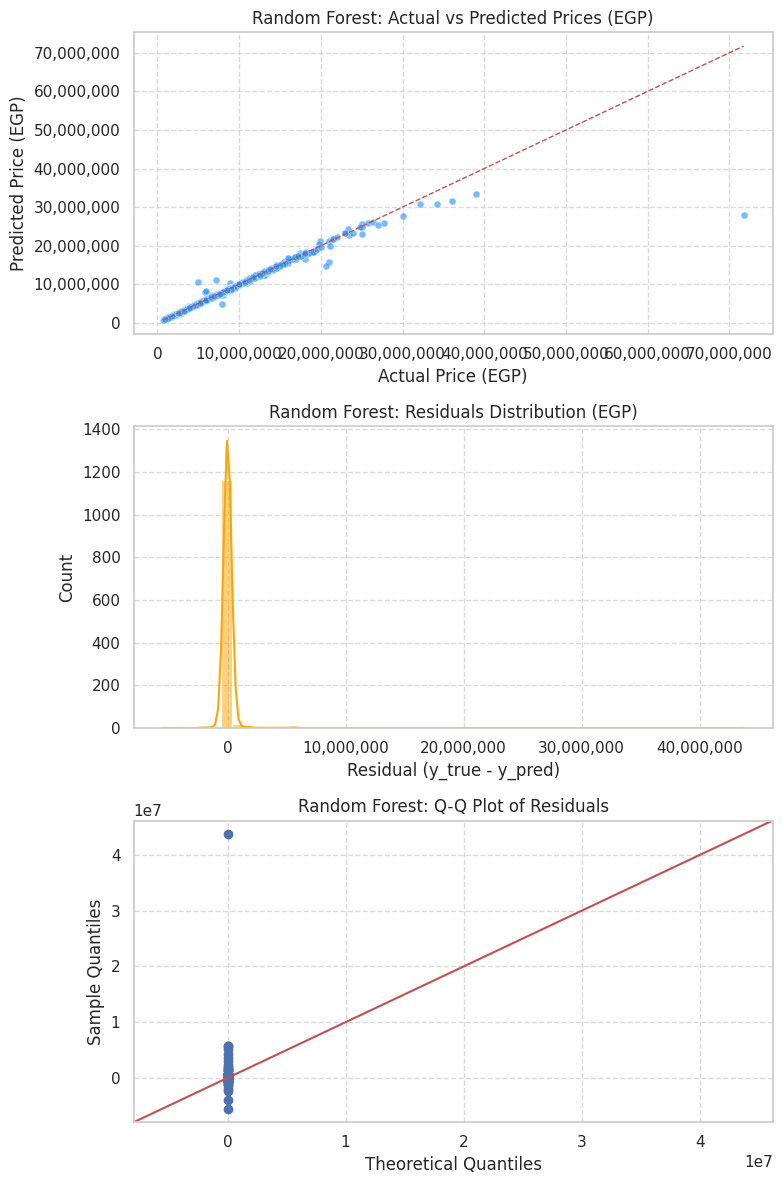

Random Forest Results:
Test R² Score  : 0.9300
Test MAE       : 155,347 EGP
Test RMSE      : 1,334,332 EGP
Cross-Validation R² Mean: 0.9920 ± 0.0049
Shapiro-Wilk p-value: 0.0000
Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [28]:
# Model 2: Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gridsearch', RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions={
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        n_iter=10,
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42
    ))
])
rf_pipeline = evaluate_model(rf_pipeline, train_data[categorical_cols + numeric_cols],
                            train_data['price_log'], test_data[categorical_cols + numeric_cols],
                            test_data['price_log'], 'Random Forest')
print("Best parameters:", rf_pipeline.named_steps['gridsearch'].best_params_)
with open('random_forest_model.pkl', 'wb') as f:
    pkl.dump(rf_pipeline, f)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


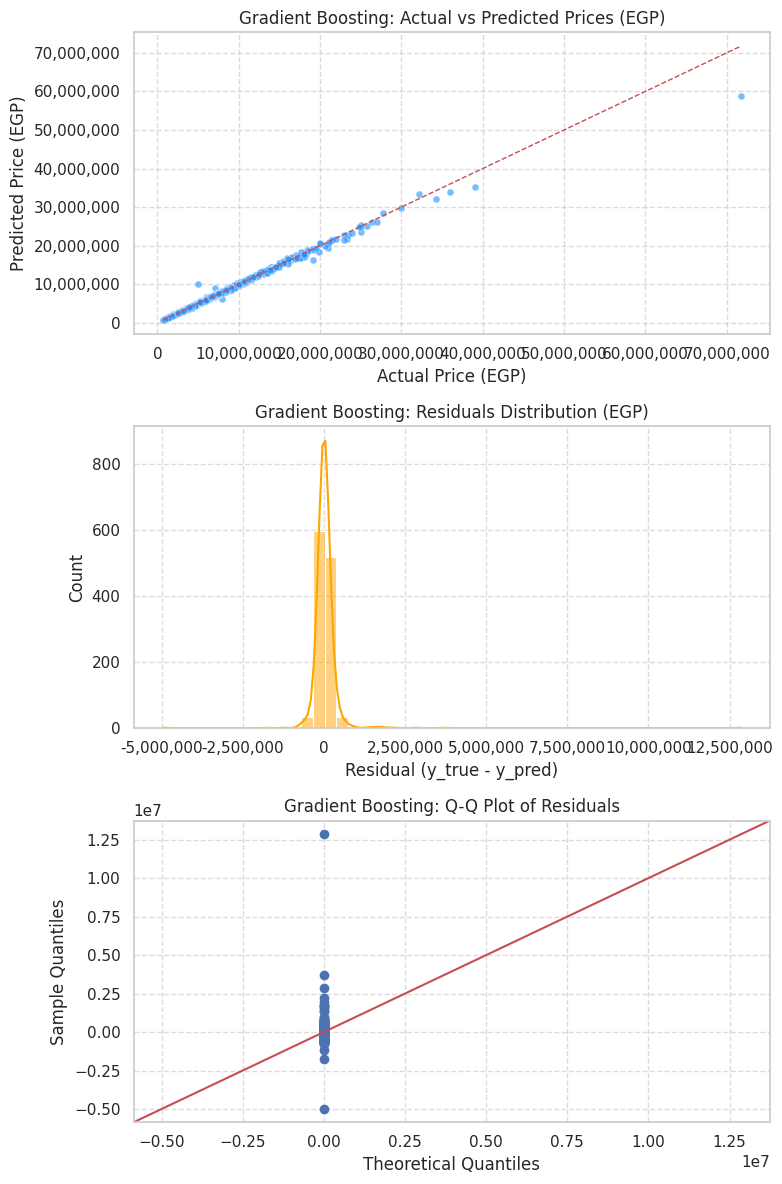

Gradient Boosting Results:
Test R² Score  : 0.9907
Test MAE       : 166,949 EGP
Test RMSE      : 485,448 EGP
Cross-Validation R² Mean: 0.9959 ± 0.0022
Shapiro-Wilk p-value: 0.0000
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 400}


In [29]:
# Model 3: Gradient Boosting
gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gridsearch', GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_grid={
            'n_estimators': [200, 400],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5]
        },
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1
    ))
])
gbr_pipeline = evaluate_model(gbr_pipeline, train_data[categorical_cols + numeric_cols],
                             train_data['price_log'], test_data[categorical_cols + numeric_cols],
                             test_data['price_log'], 'Gradient Boosting')
print("Best parameters:", gbr_pipeline.named_steps['gridsearch'].best_params_)
with open('gradient_boosting_model.pkl', 'wb') as f:
    pkl.dump(gbr_pipeline, f)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


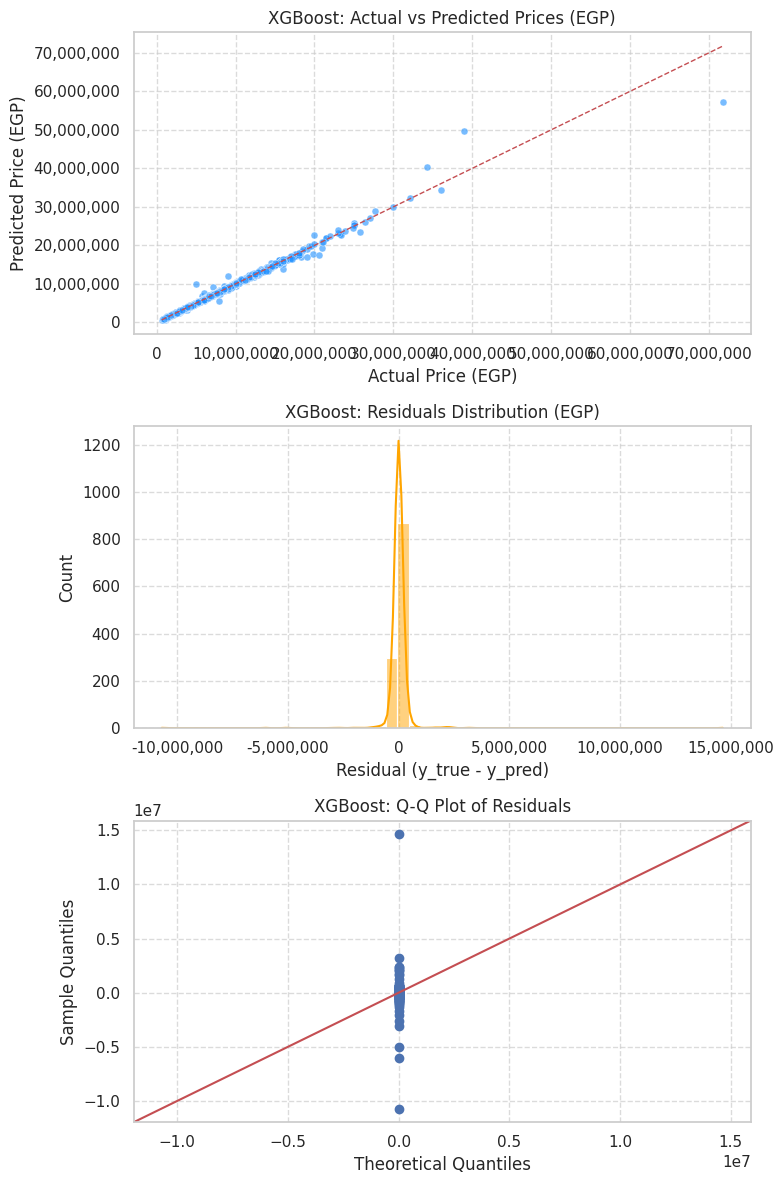

XGBoost Results:
Test R² Score  : 0.9840
Test MAE       : 158,758 EGP
Test RMSE      : 638,284 EGP
Cross-Validation R² Mean: 0.9932 ± 0.0044
Shapiro-Wilk p-value: 0.0000
Best parameters: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [30]:
# Model 4: XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gridsearch', RandomizedSearchCV(
        estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
        param_distributions={
            'n_estimators': [200, 400, 600],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
        },
        n_iter=10,
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42
    ))
])
xgb_pipeline = evaluate_model(xgb_pipeline, train_data[categorical_cols + numeric_cols],
                             train_data['price_log'], test_data[categorical_cols + numeric_cols],
                             test_data['price_log'], 'XGBoost')
print("Best parameters:", xgb_pipeline.named_steps['gridsearch'].best_params_)
with open('xgb_model.pkl', 'wb') as f:
    pkl.dump(xgb_pipeline, f)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 3614, number of used features: 79
[LightGBM] [Info] Start training from score 15.653189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

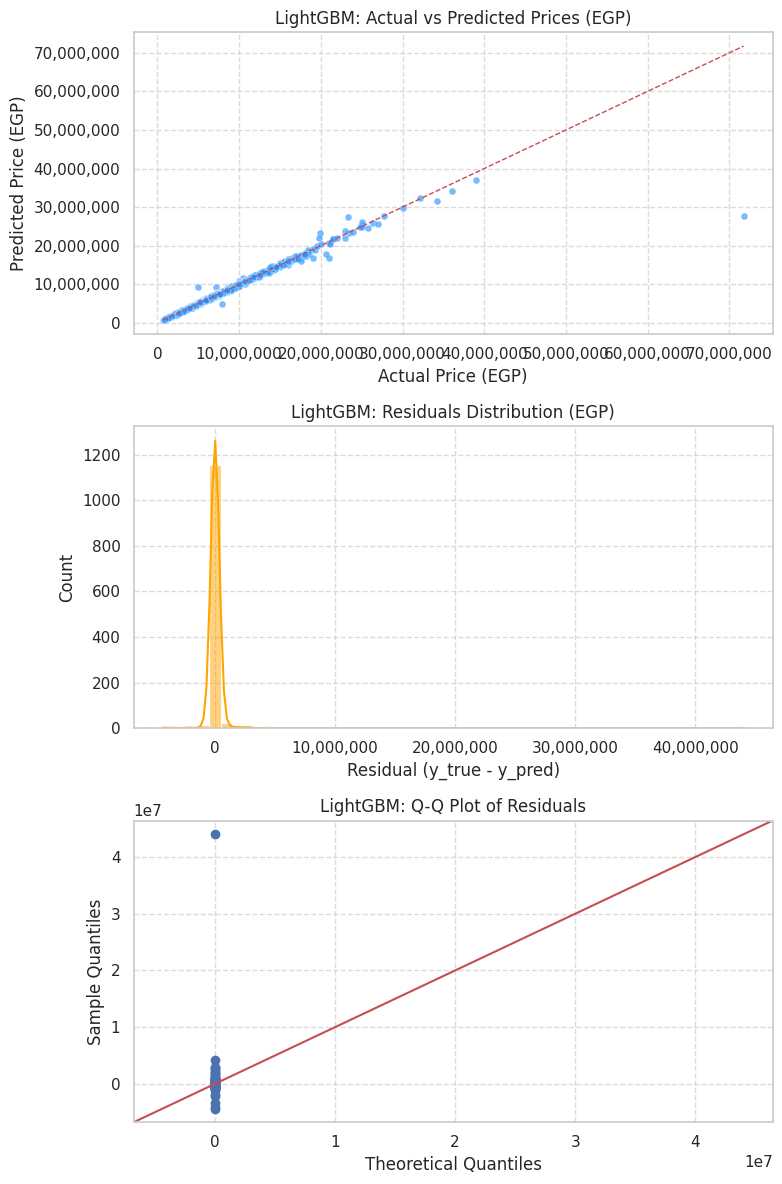

LightGBM Results:
Test R² Score  : 0.9316
Test MAE       : 203,091 EGP
Test RMSE      : 1,318,970 EGP
Cross-Validation R² Mean: 0.9914 ± 0.0041
Shapiro-Wilk p-value: 0.0000
Best parameters: {'num_leaves': 20, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05}


In [31]:
# Model 5: LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gridsearch', RandomizedSearchCV(
        estimator=LGBMRegressor(random_state=42),
        param_distributions={
            'n_estimators': [200, 400, 600],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'num_leaves': [20, 31, 50]
        },
        n_iter=10,
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42
    ))
])
lgbm_pipeline = evaluate_model(lgbm_pipeline, train_data[categorical_cols + numeric_cols],
                              train_data['price_log'], test_data[categorical_cols + numeric_cols],
                              test_data['price_log'], 'LightGBM')
print("Best parameters:", lgbm_pipeline.named_steps['gridsearch'].best_params_)
with open('lightgbm_model.pkl', 'wb') as f:
    pkl.dump(lgbm_pipeline, f)



Model Comparison:
               Model        R²     MAE (EGP)    RMSE (EGP)  CV R² Mean  \
0  Linear Regression  0.503119  1.175806e+06  3.554851e+06   -1.352426   
1      Random Forest  0.929994  1.553473e+05  1.334332e+06    0.992024   
2  Gradient Boosting  0.990734  1.669486e+05  4.854481e+05    0.995855   
3            XGBoost  0.983981  1.587579e+05  6.382837e+05    0.993218   
4           LightGBM  0.931596  2.030908e+05  1.318970e+06    0.991405   

   CV R² Std  Shapiro p-value  
0   4.013232     4.634983e-54  
1   0.004912     3.626432e-60  
2   0.002241     1.490076e-54  
3   0.004370     7.617988e-57  
4   0.004123     7.222578e-60  


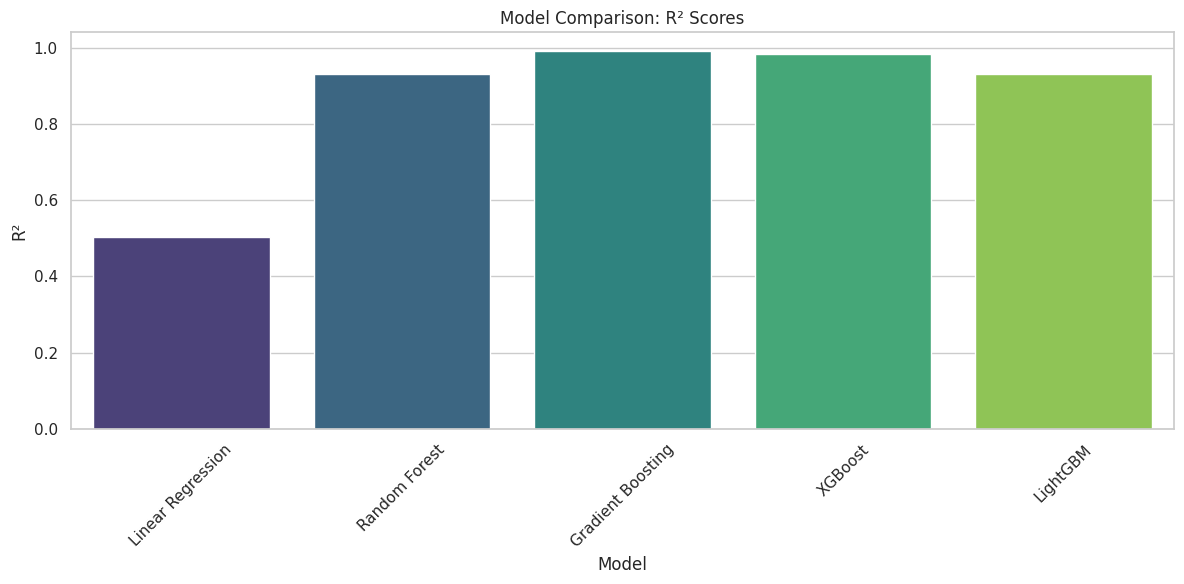

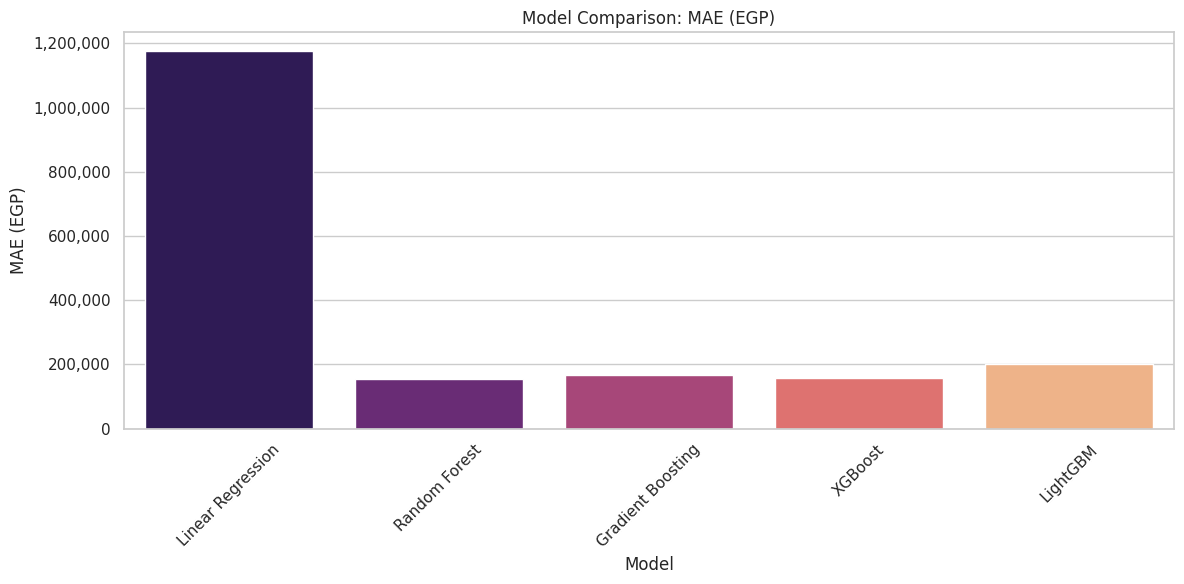

In [34]:
# ================== Model Comparison ==================
results_df = pd.DataFrame(model_results)
print("\nModel Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='R²', palette='viridis')
plt.title('Model Comparison: R² Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='MAE (EGP)', palette='magma')
plt.title('Model Comparison: MAE (EGP)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

# Save enhanced data
data.to_csv('Dubizzle_properties_enhanced.csv', index=False)